In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree

In [2]:
caminho_arquivo = './dados/MICRODADOS_ENEM_2023.csv'
data = pd.read_csv(caminho_arquivo, encoding='latin1', sep=';')
num_columns = data.shape[1]
num_rows = data.shape[0]
print(f"Número de colunas: {num_columns}")
print(f"Número de linhas: {num_rows}")
data.head()

Número de colunas: 76
Número de linhas: 3933955


,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,210059085136,2023,14,M,2,1,1,1,17,1,...,C,C,B,B,A,B,B,A,A,B
1,210059527735,2023,12,M,2,1,0,1,16,1,...,B,A,B,B,A,A,C,A,D,B
2,210061103945,2023,6,F,1,1,1,1,0,1,...,B,A,A,B,A,A,A,A,A,B
3,210060214087,2023,2,F,1,3,1,2,0,2,...,A,A,A,B,A,A,D,A,A,B
4,210059980948,2023,3,F,1,3,1,2,0,2,...,A,A,A,B,A,A,B,A,A,A


In [3]:
#função tratar nulos
def tratarNulos(dados):
    dataset = dados.copy()  # evita problemas de referência
    
    # Colunas numéricas que representam categorias
    colunas_categoricas_numericas = [
        'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
        'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
        'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC','Q006',
        'Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014','Q015','Q016','Q017','Q018','Q019'
    ]
    
    for col in dataset.columns:
        if dataset[col].isnull().any():  # só trata se houver nulos
            if col in colunas_categoricas_numericas:
                # Para categóricas → moda
                moda = dataset[col].mode()
                if not moda.empty:
                    dataset[col] = dataset[col].fillna(moda.iloc[0])
            else:
                # Para numéricas contínuas → média
                media = dataset[col].mean()
                dataset[col] = dataset[col].fillna(media)
    
    return dataset

In [4]:
dados_selecionados = data[['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO','Q006', 'Q007','Q008','Q009','Q010','Q011',
                       'Q012','Q013','Q014','Q015','Q016',
                       'Q017','Q018','Q019']]

In [5]:
print("Antes:")
print(dados_selecionados.isnull().sum()[data.isnull().sum() > 0])
dataset_sem_nulos  = tratarNulos(dados_selecionados)
print("\nDepois:")
print(dataset_sem_nulos.isnull().sum()[dataset_sem_nulos.isnull().sum() > 0])

Antes:
TP_ENSINO             2594874
TP_LOCALIZACAO_ESC    2975449
NU_NOTA_CN            1241528
NU_NOTA_CH            1111312
NU_NOTA_LC            1111312
NU_NOTA_MT            1241528
NU_NOTA_REDACAO       1111312
dtype: int64

Depois:
Series([], dtype: int64)


In [6]:
# Dicionário para mapear as respostas da questão Q006 (faixa de renda) em classes sociais
mapa_renda = {
    'A': 'E',
    'B': 'D',
    'C': 'D',
    'D': 'C',
    'E': 'C',
    'F': 'B',
    'G': 'B',
    'H': 'A',
    'I': 'A',
    'J': 'A',
    'K': 'A',
    'L': 'A',
    'M': 'A',
    'N': 'A',
    'O': 'A',
    'P': 'A',
    'Q': 'A'
}

# Criar nova coluna 'classe_social' baseada na resposta da questão Q006
dataset_sem_nulos['classe_social'] = dataset_sem_nulos['Q006'].map(mapa_renda)
dataset_sem_nulos = dataset_sem_nulos.drop(columns=['Q006'])

In [7]:
num_columns = dataset_sem_nulos.shape[1]
num_rows = dataset_sem_nulos.shape[0]
print(f"Número de colunas: {num_columns}")
print(f"Número de linhas: {num_rows}")
dataset_sem_nulos.head()

Número de colunas: 29
Número de linhas: 3933955


,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_LOCALIZACAO_ESC,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,classe_social
0,14,M,2,1,1,1,17,1,1.0,1.0,...,D,C,B,B,D,C,C,B,B,B
1,12,M,2,1,0,1,16,1,1.0,1.0,...,A,B,B,B,A,B,A,B,B,A
2,6,F,1,1,1,1,0,1,1.0,1.0,...,A,B,A,B,A,B,A,A,B,D
3,2,F,1,3,1,2,0,2,1.0,1.0,...,A,B,A,A,A,A,A,A,B,D
4,3,F,1,3,1,2,0,2,1.0,1.0,...,A,B,A,A,A,A,A,A,B,D


In [8]:
# 1. Separar X e y
X = dataset_sem_nulos.drop(columns=['classe_social'])
y = dataset_sem_nulos['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('classificador', clf) 
])



# 6. Treinar modelo
modelo.fit(X, y)

# 7. Avaliar
y_pred = modelo.predict(X)
print("Acurácia:", accuracy_score(y, y_pred))
print("\nRelatório de classificação:\n", classification_report(y, y_pred))
print("\nMatriz de confusão:\n", confusion_matrix(y, y_pred))

# 8. Visualizar a árvore em texto
arvore_texto = export_text(modelo.named_steps['classificador'],
                           feature_names=modelo.named_steps['preprocessador'].get_feature_names_out())
print(arvore_texto)

Acurácia: 0.942172953173079

Relatório de classificação:
               precision    recall  f1-score   support

           A       0.98      0.98      0.98    605658
           B       0.96      0.94      0.95    432671
           C       0.94      0.90      0.92    731360
           D       0.92      0.98      0.95   1896213
           E       0.99      0.73      0.84    268053

    accuracy                           0.94   3933955
   macro avg       0.96      0.90      0.93   3933955
weighted avg       0.94      0.94      0.94   3933955


Matriz de confusão:
 [[ 594688    1967    4096    4892      15]
 [   5049  404709    7627   15253      33]
 [   5448    7820  655761   62108     223]
 [   3982    7500   26309 1855906    2516]
 [    305     587    2357   69402  195402]]
|--- cat__Q010_A <= 0.50
|   |--- cat__Q008_B <= 0.50
|   |   |--- cat__Q007_A <= 0.50
|   |   |   |--- cat__Q008_C <= 0.50
|   |   |   |   |--- cat__Q018_A <= 0.50
|   |   |   |   |   |--- cat__Q008_E <= 0.50
|   |

In [10]:
def analisar_importancia_features_agregada(modelo, clf, categoricas, top_n=None):
    """
    Exibe a importância das features de um modelo DecisionTreeClassifier,
    somando as importâncias das dummies das features categóricas.

    Parâmetros:
    - modelo: pipeline treinado (com preprocessador + classificador)
    - clf: classificador treinado (ex: DecisionTreeClassifier)
    - categoricas: lista de colunas categóricas originais
    - top_n: se quiser mostrar só as N variáveis mais importantes (opcional)

    Retorna:
    - df_agregado: DataFrame com importância agregada por feature
    """

    # Extrair nomes das features pós-transformação
    nomes_features = modelo.named_steps['preprocessador'].get_feature_names_out()
    
    # Importâncias
    importances = clf.feature_importances_
    
    # Criar DataFrame
    df = pd.DataFrame({
        'feature_expandida': nomes_features,
        'importancia': importances
    })
    
    # Inicializar coluna de feature original
    df['feature_original'] = df['feature_expandida']
    
    # Mapear dummies categóricas para a feature original
    for cat in categoricas:
        mask = df['feature_expandida'].str.contains(f"__{cat}_")
        df.loc[mask, 'feature_original'] = cat
    
    # Agregar importâncias por feature original
    df_agregado = df.groupby('feature_original')['importancia'].sum().sort_values(ascending=False)
    
    # Filtrar top_n se necessário
    if top_n:
        df_agregado = df_agregado.head(top_n)
    
    # Print em texto
    print("Importância das features (agregada):")
    for feat, imp in df_agregado.items():
        print(f"Feature {feat}: {imp:.4f}")
    
    # Gráfico
    plt.figure(figsize=(10,6))
    plt.bar(range(len(df_agregado)), df_agregado.values, align="center")
    plt.xticks(range(len(df_agregado)), df_agregado.index, rotation=90)
    plt.title("Importância das Features (DecisionTreeClassifier)")
    plt.tight_layout()
    plt.show()
    
    return df_agregado

Importância das features (agregada):
Feature Q010: 0.1347
Feature num__NU_NOTA_MT: 0.1060
Feature num__NU_NOTA_LC: 0.0993
Feature num__NU_NOTA_CH: 0.0989
Feature num__NU_NOTA_CN: 0.0945
Feature num__NU_NOTA_REDACAO: 0.0676
Feature Q008: 0.0521
Feature num__TP_FAIXA_ETARIA: 0.0508
Feature num__TP_COR_RACA: 0.0319
Feature num__TP_ANO_CONCLUIU: 0.0304
Feature Q007: 0.0253
Feature Q009: 0.0231
Feature Q011: 0.0216
Feature Q014: 0.0197
Feature Q018: 0.0190
Feature Q013: 0.0167
Feature TP_SEXO: 0.0163
Feature num__TP_ESTADO_CIVIL: 0.0161
Feature Q019: 0.0151
Feature Q015: 0.0127


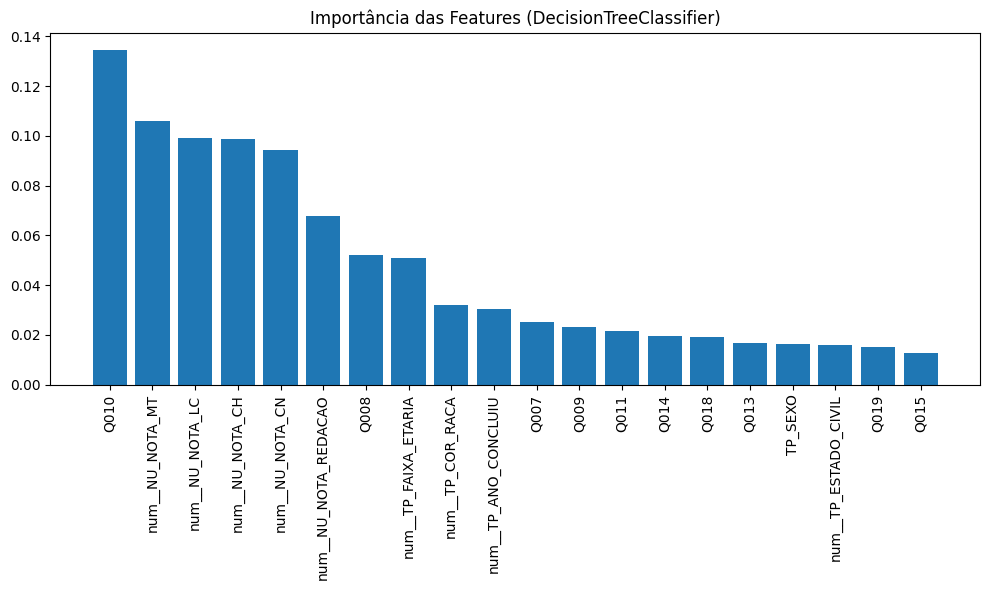

In [11]:
df_importancia = analisar_importancia_features_agregada(modelo, clf, categoricas, 20)


In [12]:
def analisar_quartis_por_classe(dataset):
    """
    Função para analisar a distribuição da classe social em cada quartil de notas.
    
    Parâmetros:
        dataset (pd.DataFrame): dataset com colunas 'NU_NOTA_CN', 'NU_NOTA_CH',
                                'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO' e 'classe_social'.
    
    Retorno:
        pd.DataFrame: tabela com distribuição percentual da classe social por quartil de notas.
    """

    # Cria uma coluna com a média das notas
    dataset['media_notas'] = dataset[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
                                      'NU_NOTA_MT', 'NU_NOTA_REDACAO']].mean(axis=1)

    # Divide em quartis
    dataset['quartil_notas'] = pd.qcut(dataset['media_notas'], 4, 
                                       labels=['1º Quartil (mais baixo)', 
                                               '2º Quartil', 
                                               '3º Quartil', 
                                               '4º Quartil (mais alto)'])

    # Calcula a distribuição percentual
    tabela = (dataset.groupby('quartil_notas')['classe_social']
                     .value_counts(normalize=True)
                     .rename('proporcao')
                     .reset_index())

    # Transforma em tabela no formato que você mostrou
    tabela_pivot = tabela.pivot(index='quartil_notas', 
                                columns='classe_social', 
                                values='proporcao')

    print("\nDistribuição de classe social por quartil de notas:\n")
    print(tabela_pivot)

    return tabela_pivot

In [16]:
def analisar_quartis_com_modelo(modelo, X):
    # Faz as previsões
    y_pred = modelo.predict(X)

    # Cria DataFrame com notas + previsão
    df = X.copy()
    df['classe_prevista'] = y_pred
    df['media_notas'] = X[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
                           'NU_NOTA_MT', 'NU_NOTA_REDACAO']].mean(axis=1)

    # Divide em quartis
    df['quartil_notas'] = pd.qcut(df['media_notas'], 4,
                                  labels=['1º Quartil (mais baixo)',
                                          '2º Quartil',
                                          '3º Quartil',
                                          '4º Quartil (mais alto)'])

    # Tabela de distribuição
    tabela = (df.groupby('quartil_notas')['classe_prevista']
                .value_counts(normalize=True)
                .rename('proporcao')
                .reset_index())

    tabela_pivot = tabela.pivot(index='quartil_notas',
                                columns='classe_prevista',
                                values='proporcao')

    print("\nDistribuição da classe prevista pelo modelo em cada quartil de notas:\n")
    print(tabela_pivot)

    return tabela_pivot

In [13]:
resultado_quartis_dataset_geral = analisar_quartis_por_classe(dataset_sem_nulos)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_16496\983165651.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = (dataset.groupby('quartil_notas')['classe_social']



Distribuição de classe social por quartil de notas:

classe_social                   A         B         C         D         E
quartil_notas                                                            
1º Quartil (mais baixo)  0.057492  0.069125  0.160126  0.607340  0.105917
2º Quartil               0.087729  0.088998  0.187913  0.553041  0.082319
3º Quartil               0.157331  0.137551  0.223190  0.440768  0.041160
4º Quartil (mais alto)   0.353864  0.172567  0.192974  0.261434  0.019161


In [15]:
resultado_modelo = analisar_quartis_com_modelo(modelo, X)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_16496\92591484.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = (df.groupby('quartil_notas')['classe_prevista']



Distribuição da classe prevista pelo modelo em cada quartil de notas:

classe_prevista                 A         B         C         D         E
quartil_notas                                                            
1º Quartil (mais baixo)  0.057492  0.069126  0.160129  0.607336  0.105917
2º Quartil               0.090179  0.082517  0.165291  0.624576  0.037438
3º Quartil               0.157331  0.137551  0.223190  0.440768  0.041160
4º Quartil (mais alto)   0.353864  0.172567  0.192974  0.261434  0.019161


In [17]:
# Filtrar apenas escolas urbanas
dataset_urbano = dataset_sem_nulos[dataset_sem_nulos['TP_LOCALIZACAO_ESC'] == 1]

# Filtrar apenas escolas rurais
dataset_rural = dataset_sem_nulos[dataset_sem_nulos['TP_LOCALIZACAO_ESC'] == 2]

In [19]:
# 1. Separar X e y
X_urbano = dataset_urbano.drop(columns=['classe_social'])
y_urbano = dataset_urbano['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_urbano = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_urbano = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_urbano = Pipeline(steps=[
    ('preprocessador', preprocessador_urbano),
    ('classificador', clf_urbano) 
])



# 6. Treinar modelo
modelo_urbano.fit(X_urbano, y_urbano)

# 7. Avaliar
y_pred_urbano = modelo_urbano.predict(X_urbano)
print("Acurácia:", accuracy_score(y_urbano, y_pred_urbano))
print("\nRelatório de classificação:\n", classification_report(y_urbano, y_pred_urbano))
print("\nMatriz de confusão:\n", confusion_matrix(y_urbano, y_pred_urbano))

# 8. Visualizar a árvore em texto
arvore_texto = export_text(modelo_urbano.named_steps['classificador'],
                           feature_names=modelo_urbano.named_steps['preprocessador'].get_feature_names_out())
print(arvore_texto)

Acurácia: 0.9418998769978234

Relatório de classificação:
               precision    recall  f1-score   support

           A       0.98      0.98      0.98    603429
           B       0.96      0.94      0.95    429980
           C       0.94      0.90      0.92    726283
           D       0.92      0.98      0.95   1874425
           E       0.99      0.73      0.84    264188

    accuracy                           0.94   3898305
   macro avg       0.96      0.90      0.93   3898305
weighted avg       0.94      0.94      0.94   3898305


Matriz de confusão:
 [[ 592470    1967    4093    4884      15]
 [   5048  402041    7623   15235      33]
 [   5446    7804  650830   61982     221]
 [   3979    7468   26227 1834265    2486]
 [    302     584    2345   68750  192207]]
|--- cat__Q010_A <= 0.50
|   |--- cat__Q008_B <= 0.50
|   |   |--- cat__Q007_A <= 0.50
|   |   |   |--- cat__Q008_C <= 0.50
|   |   |   |   |--- cat__Q018_A <= 0.50
|   |   |   |   |   |--- cat__Q008_E <= 0.50
|   

In [20]:
resultado_quartis_dataset_urbano = analisar_quartis_por_classe(dataset_urbano)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_16496\983165651.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
C:\Users\Carlos\AppData\Local\Temp\ipykernel_16496\983165651.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['quartil_notas'] = pd.qcut(dataset['media_notas'], 4,
C:\Users\Carlos\AppData\Local\Temp\ipykernel_16496\983165651.py:25: FutureWarning: The default of observed=False is deprecated and will be changed


Distribuição de classe social por quartil de notas:

classe_social                   A         B         C         D         E
quartil_notas                                                            
1º Quartil (mais baixo)  0.057946  0.069512  0.160834  0.606353  0.105354
2º Quartil               0.088234  0.089307  0.188486  0.552011  0.081962
3º Quartil               0.158115  0.137888  0.223326  0.439718  0.040954
4º Quartil (mais alto)   0.355375  0.172643  0.192773  0.260164  0.019046


In [21]:
resultado_modelo_urbano = analisar_quartis_com_modelo(modelo_urbano, X_urbano)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_16496\92591484.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = (df.groupby('quartil_notas')['classe_prevista']



Distribuição da classe prevista pelo modelo em cada quartil de notas:

classe_prevista                 A         B         C         D         E
quartil_notas                                                            
1º Quartil (mais baixo)  0.057946  0.069513  0.160837  0.606349  0.105354
2º Quartil               0.090713  0.082734  0.165638  0.623930  0.036986
3º Quartil               0.158115  0.137888  0.223326  0.439718  0.040954
4º Quartil (mais alto)   0.355375  0.172643  0.192773  0.260164  0.019046


Importância das features (agregada):
Feature Q010: 0.1349
Feature num__NU_NOTA_MT: 0.1061
Feature num__NU_NOTA_LC: 0.0994
Feature num__NU_NOTA_CH: 0.0994
Feature num__NU_NOTA_CN: 0.0947
Feature num__NU_NOTA_REDACAO: 0.0678
Feature Q008: 0.0522
Feature num__TP_FAIXA_ETARIA: 0.0511
Feature num__TP_COR_RACA: 0.0321
Feature num__TP_ANO_CONCLUIU: 0.0305
Feature Q007: 0.0255
Feature Q009: 0.0229
Feature Q011: 0.0214
Feature Q014: 0.0197
Feature Q018: 0.0191
Feature Q013: 0.0165
Feature TP_SEXO: 0.0164
Feature num__TP_ESTADO_CIVIL: 0.0163
Feature Q019: 0.0151
Feature Q015: 0.0125


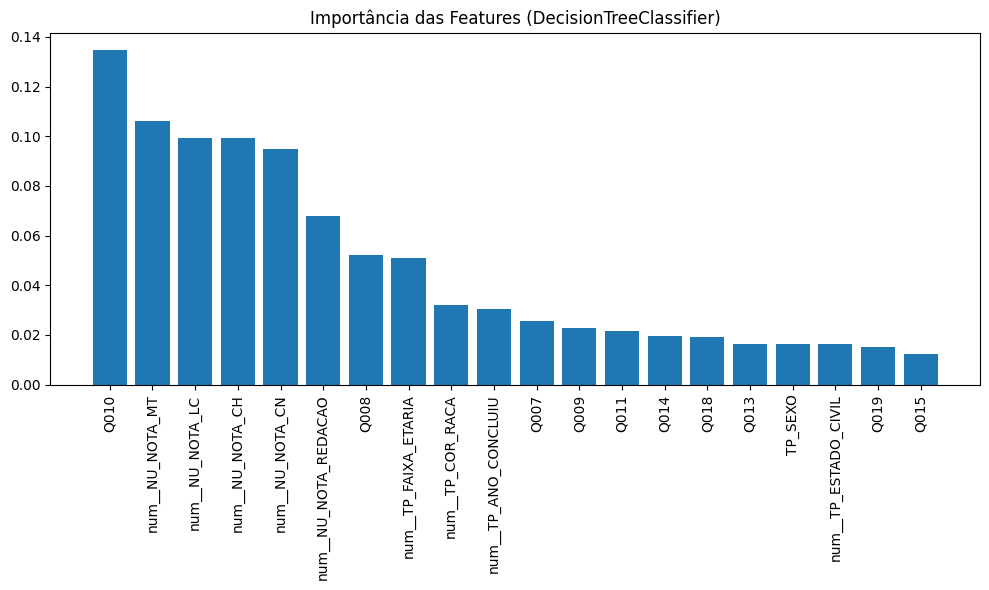

In [22]:
df_importancia_urbano = analisar_importancia_features_agregada(modelo_urbano, clf_urbano, categoricas, 20)

In [23]:
# 1. Separar X e y
X_rural = dataset_rural.drop(columns=['classe_social'])
y_rural = dataset_rural['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_rural = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_rural = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_rural = Pipeline(steps=[
    ('preprocessador', preprocessador_rural),
    ('classificador', clf_rural) 
])



# 6. Treinar modelo
modelo_rural.fit(X_rural, y_rural)

# 7. Avaliar
y_pred_rural = modelo_rural.predict(X_rural)
print("Acurácia:", accuracy_score(y_rural, y_pred_rural))
print("\nRelatório de classificação:\n", classification_report(y_rural, y_pred_rural))
print("\nMatriz de confusão:\n", confusion_matrix(y_rural, y_pred_rural))

# 8. Visualizar a árvore em texto
arvore_texto_rural = export_text(modelo_rural.named_steps['classificador'],
                           feature_names=modelo_rural.named_steps['preprocessador'].get_feature_names_out())
print(arvore_texto_rural)

Acurácia: 0.9720336605890603

Relatório de classificação:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00      2229
           B       0.98      0.99      0.99      2691
           C       0.98      0.97      0.98      5077
           D       0.96      0.99      0.98     21788
           E       0.99      0.83      0.90      3865

    accuracy                           0.97     35650
   macro avg       0.98      0.96      0.97     35650
weighted avg       0.97      0.97      0.97     35650


Matriz de confusão:
 [[ 2218     0     3     8     0]
 [    1  2668     4    18     0]
 [    2    16  4931   126     2]
 [    3    32    82 21641    30]
 [    3     3    12   652  3195]]
|--- cat__Q010_A <= 0.50
|   |--- cat__Q008_B <= 0.50
|   |   |--- cat__Q007_A <= 0.50
|   |   |   |--- cat__Q008_C <= 0.50
|   |   |   |   |--- cat__Q008_A <= 0.50
|   |   |   |   |   |--- cat__Q018_A <= 0.50
|   |   |   |   |   |   |--- cat__Q007_B <= 0.50
|   |

In [24]:
resultado_quartis_dataset_rural = analisar_quartis_por_classe(dataset_rural)


Distribuição de classe social por quartil de notas:

classe_social                   A         B         C         D         E
quartil_notas                                                            
1º Quartil (mais baixo)  0.022885  0.036123  0.098721  0.688804  0.153466
2º Quartil               0.035428  0.057005  0.129178  0.657395  0.120994
3º Quartil               0.059659  0.065341  0.215909  0.585227  0.073864
4º Quartil (mais alto)   0.155408  0.151481  0.209156  0.443896  0.040058


C:\Users\Carlos\AppData\Local\Temp\ipykernel_16496\983165651.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
C:\Users\Carlos\AppData\Local\Temp\ipykernel_16496\983165651.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['quartil_notas'] = pd.qcut(dataset['media_notas'], 4,
C:\Users\Carlos\AppData\Local\Temp\ipykernel_16496\983165651.py:25: FutureWarning: The default of observed=False is deprecated and will be changed

In [25]:
resultado_modelo_rural = analisar_quartis_com_modelo(modelo_rural, X_rural)


Distribuição da classe prevista pelo modelo em cada quartil de notas:

classe_prevista                 A         B         C         D         E
quartil_notas                                                            
1º Quartil (mais baixo)  0.022885  0.036123  0.098721  0.688804  0.153466
2º Quartil               0.035314  0.058608  0.126603  0.694998  0.084478
3º Quartil               0.059659  0.065341  0.215909  0.585227  0.073864
4º Quartil (mais alto)   0.155408  0.151481  0.209156  0.443896  0.040058


C:\Users\Carlos\AppData\Local\Temp\ipykernel_16496\92591484.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = (df.groupby('quartil_notas')['classe_prevista']


Importância das features (agregada):
Feature Q010: 0.1081
Feature num__NU_NOTA_CH: 0.1023
Feature num__NU_NOTA_LC: 0.1020
Feature num__NU_NOTA_MT: 0.1015
Feature num__NU_NOTA_CN: 0.1001
Feature num__NU_NOTA_REDACAO: 0.0743
Feature num__TP_FAIXA_ETARIA: 0.0532
Feature num__TP_COR_RACA: 0.0417
Feature Q008: 0.0399
Feature Q009: 0.0378
Feature Q011: 0.0366
Feature Q019: 0.0281
Feature TP_SEXO: 0.0276
Feature Q013: 0.0263
Feature Q014: 0.0196
Feature Q015: 0.0170
Feature Q016: 0.0151
Feature Q012: 0.0148
Feature Q007: 0.0137
Feature num__TP_ESTADO_CIVIL: 0.0125


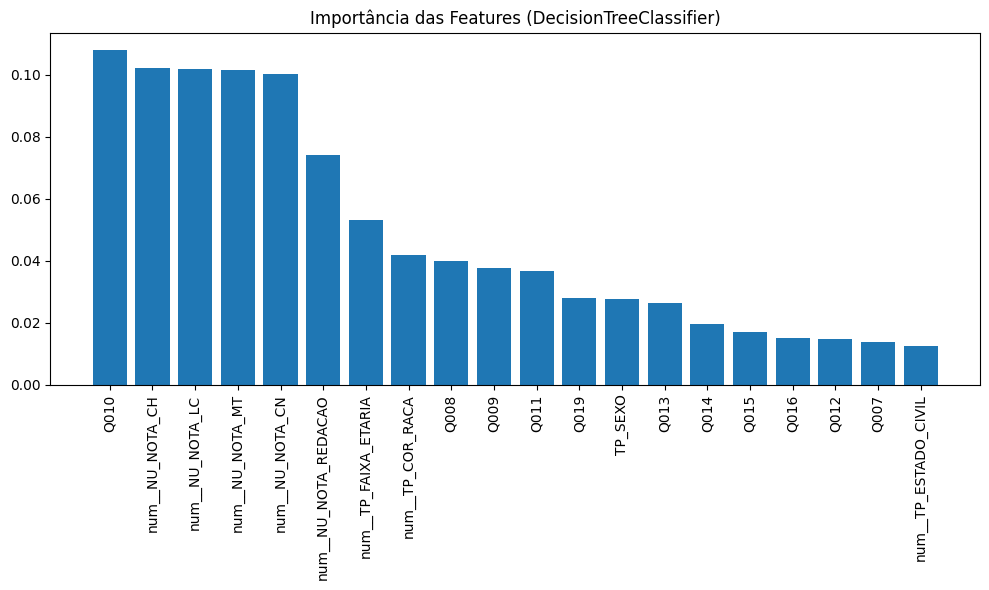

In [26]:
df_importancia_rural = analisar_importancia_features_agregada(modelo_rural,clf_rural, categoricas, top_n=20)